In [1]:
!pip install dionysus
!pip install zarr
!pip install POT
!pip install gudhi
!pip install validclust

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440669 sha256=76211f67709c66b5ba1696d451b6a6816e48e9b977e8792d4d34313aa82744cb
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.9 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=6c6efb0687d2fc78a53c6fc6933db3de2c67cfa7e9bf2c5c3b80036429ed4f34
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 10.9 MB/s eta 0:00:00
    

In [2]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
os.chdir("/content/drive/My Drive/NASA/Fire Detection/Test Data")
!ls -ltr

Mounted at /content/drive
total 115
drwx------ 2 root root  4096 Jan 19  2023 Tile_1_33
drwx------ 2 root root  4096 Jan 19  2023 Tile_5_37
drwx------ 2 root root  4096 Jan 21  2023 Tile_0_8
drwx------ 2 root root  4096 Jan 23  2023 Tile_2_6
drwx------ 2 root root  4096 Jan 23  2023 Tile_17_32
drwx------ 2 root root  4096 Jan 25  2023 Tile_13_37
-rw------- 1 root root 22342 Feb  8  2023 clusters_2norm.pdf
drwx------ 2 root root  4096 Mar  7  2023 Tile_0_35
drwx------ 2 root root  4096 Mar  7  2023 Tile_0_24
drwx------ 2 root root  4096 Mar  7  2023 Tile_0_32
drwx------ 2 root root  4096 Mar  7  2023 Tile_1_38
drwx------ 2 root root  4096 Mar  7  2023 Tile_2_32
drwx------ 2 root root  4096 Mar  7  2023 Tile_2_33
drwx------ 2 root root  4096 Mar  7  2023 Tile_2_35
drwx------ 2 root root  4096 Mar  7  2023 Tile_3_33
drwx------ 2 root root  4096 Mar  7  2023 Tile_5_35
drwx------ 2 root root  4096 Mar  7  2023 Tile_6_33
drwx------ 2 root root  4096 Mar  7  2023 Tile_6_38
drwx------ 2 root r

In [3]:
import zarr
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import dionysus as d
import matplotlib.pyplot as plt
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance as wd
from gudhi.representations import Landscape
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from validclust import dunn, cop, ValidClust
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import gudhi
sns.set_theme()

/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [4]:
fname2 = 'Tile_1_33'

rawFileList = os.listdir(fname2)
print (rawFileList)

['Tile_1_33.csv', 'Tile_1_33_s20192210221197.zarr', 'Tile_1_33_s20192192041196.zarr', 'Tile_1_33_s20192201851196.zarr', 'Tile_1_33_s20192210116197.zarr', 'Tile_1_33_s20192210121197.zarr', 'Tile_1_33_s20192192006196.zarr', 'Tile_1_33_s20192192026196.zarr', 'Tile_1_33_s20192200056197.zarr', 'Tile_1_33_s20192201931196.zarr', 'Tile_1_33_s20192200236197.zarr', 'Tile_1_33_s20192181926196.zarr', 'Tile_1_33_s20192191821196.zarr', 'Tile_1_33_s20192182036196.zarr', 'Tile_1_33_s20192181816196.zarr', 'Tile_1_33_s20192182151196.zarr', 'Tile_1_33_s20192191931196.zarr', 'Tile_1_33_s20192191956196.zarr']


In [5]:
dfLabel = pd.read_csv(fname2 + '//' + rawFileList[0])
dfLabel['name'] = dfLabel.apply(lambda row: row.scene.split('_')[3], axis=1)
label = dfLabel.loc[dfLabel['name'] == 's20192210221197', 'fire'].iloc[0]
print (label)

0


In [6]:
print (dfLabel)

    Unnamed: 0.1  Unnamed: 0           fname  ind_1  ind_2  \
0              1           1  Tile_1_33.zarr      1     33   
1              2           2  Tile_1_33.zarr      1     33   
2              3           3  Tile_1_33.zarr      1     33   
3              4           4  Tile_1_33.zarr      1     33   
4              5           5  Tile_1_33.zarr      1     33   
5              6           6  Tile_1_33.zarr      1     33   
6              7           7  Tile_1_33.zarr      1     33   
7              8           8  Tile_1_33.zarr      1     33   
8              9           9  Tile_1_33.zarr      1     33   
9             10          10  Tile_1_33.zarr      1     33   
10            11          11  Tile_1_33.zarr      1     33   
11            12          12  Tile_1_33.zarr      1     33   
12            13          13  Tile_1_33.zarr      1     33   
13            14          14  Tile_1_33.zarr      1     33   
14            15          15  Tile_1_33.zarr      1     33   
15      

In [7]:
timeSeriesName = rawFileList[1:]

channel7List = []
channel7Name = []
for name in timeSeriesName:
    channelData = np.array(zarr.open(fname2 + '//' + name)[:, :, 6]) # select channel 7
    channel7List.append(channelData)
    channel7Name.append(name)

print (len(channel7List))

17


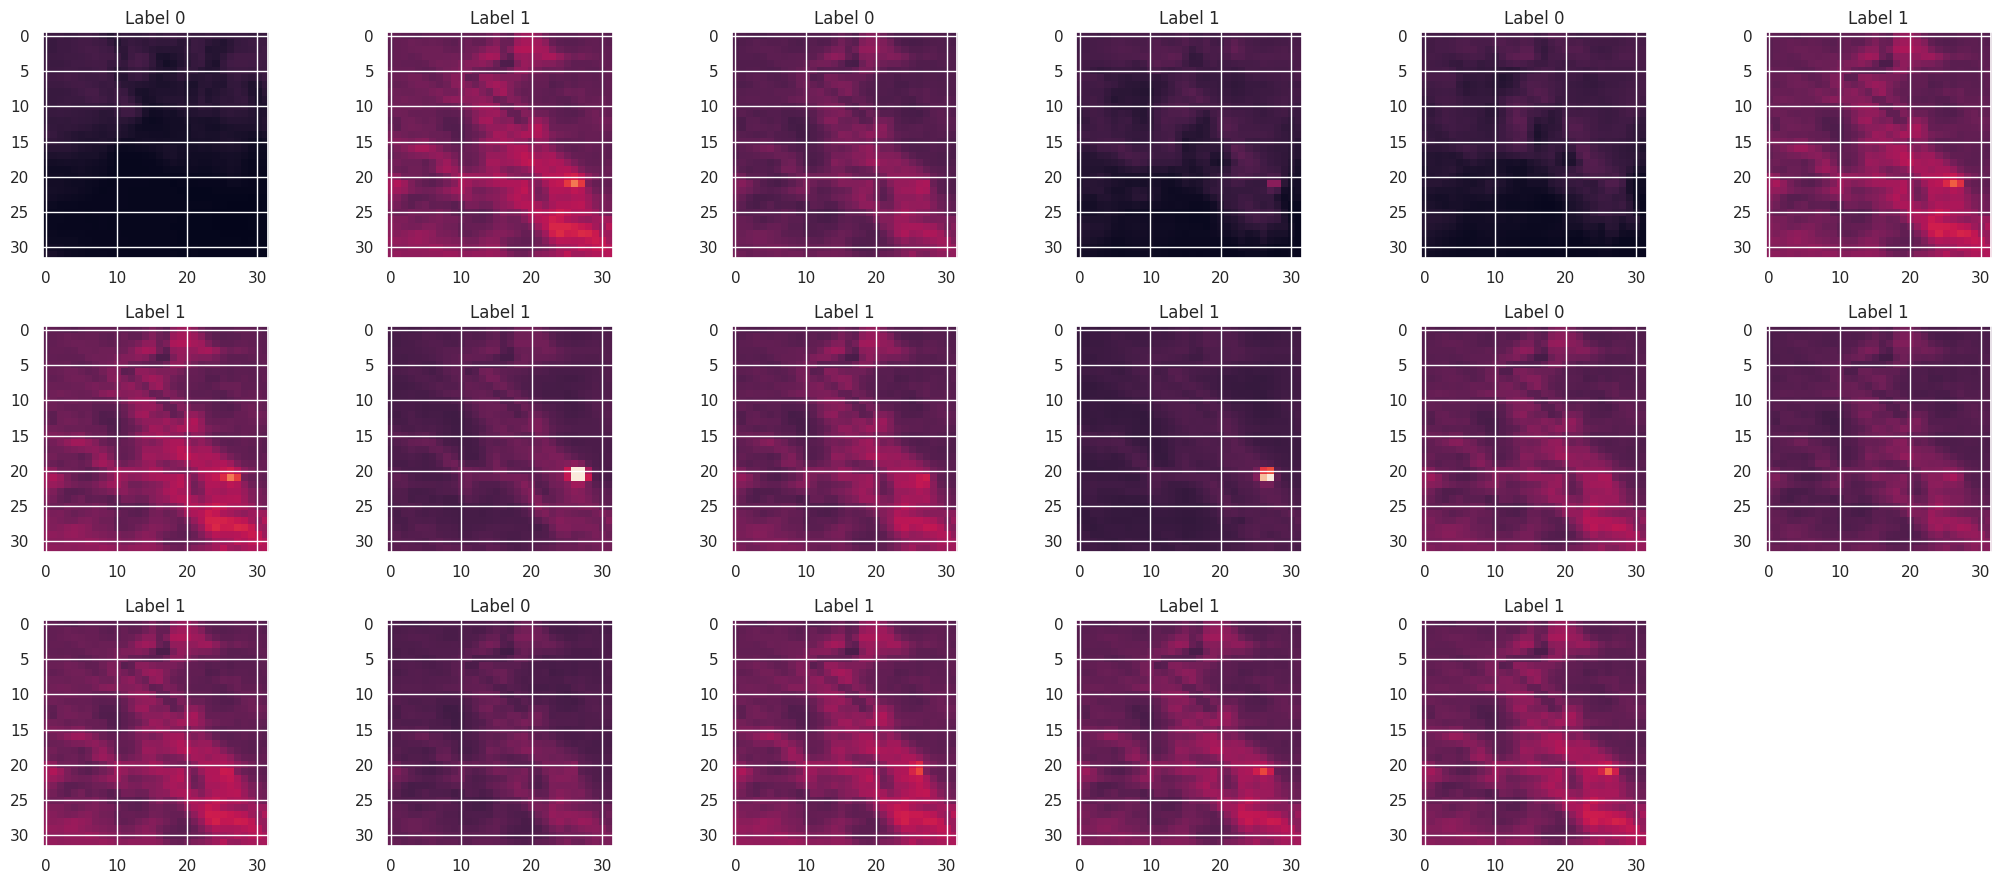

In [8]:
# plot channel 7 timeseries
fig, axs = plt.subplots(3, 6, figsize=(21, 9))

for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            axs[i, j].imshow(channel7List[i* 6 + j], vmin=0, vmax=4) # vmin, vmax may change on different tiles
            seriesStartTime = channel7Name[i* 6 + j].split('_')[3].split('.')[0]
            label = dfLabel.loc[dfLabel['name'] == seriesStartTime, 'fire'].iloc[0]
            axs[i, j].title.set_text('Label {}'.format(label))

fig.delaxes(axs[2, 5])
plt.tight_layout()

In [9]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower_bound = 0, upper_bound = 8): #change upper bound!!!!!!!!!!

    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = upper_bound
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = upper_bound

    return [[birth0,death0],[birth1,death1]]

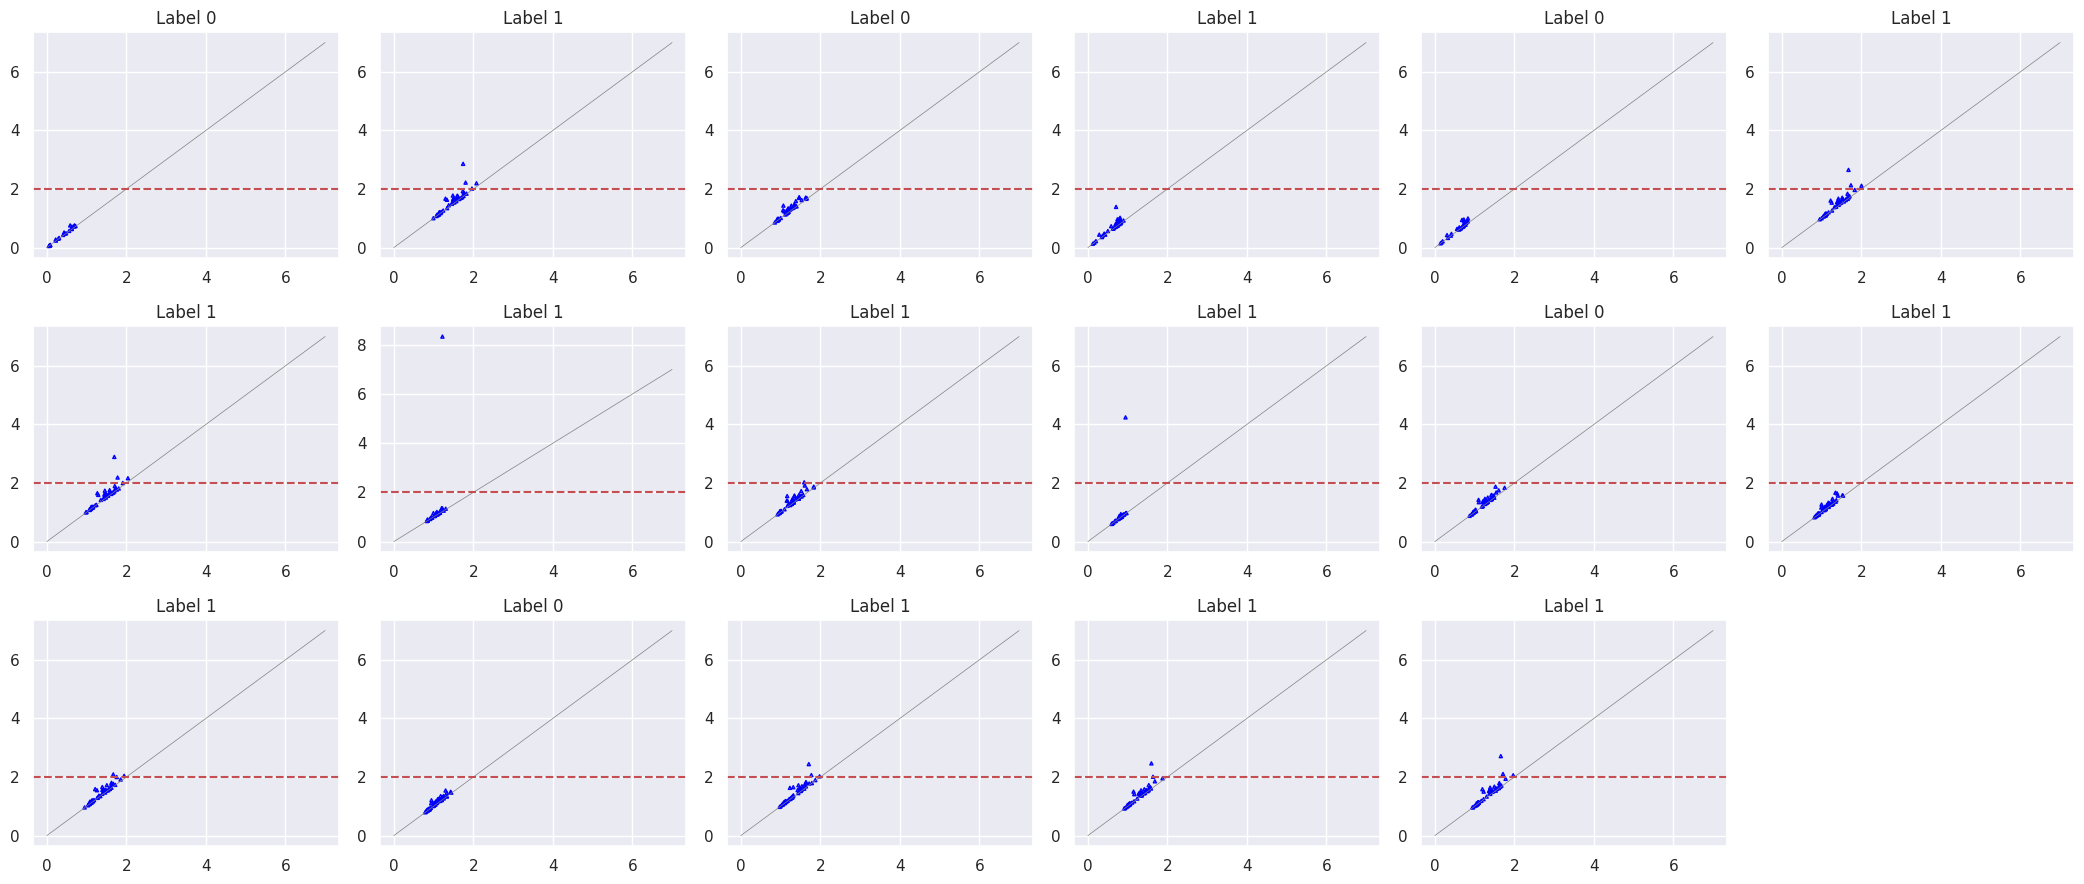

In [10]:
fig, axs = plt.subplots(3, 6, figsize=(21, 9))

pd0_union = []
pd1_union = []
groundTruth = []
for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            lower_bound = 0
            upper_bound = 8

            p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(channel7List[i* 6 + j], lower_bound = lower_bound, upper_bound = upper_bound)
            pd0_union.append(p0)
            pd1_union.append(p1)
            #axs[i, j].scatter(birth0, death0, color='r', s=5, label = 'Dimension 0')
            axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
            #axs[i, j].scatter(p0[0], p0[1], marker='^', s=5, facecolors='none', edgecolor='red', label = 'Dimension 0')
            axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
            #axs[i, j].plot(np.arange(lower_bound, upper_bound), 2, '-', color='grey', lw=0.5)
            axs[i, j].axhline(y = 2, color='r', linestyle='--')

            seriesStartTime = channel7Name[i* 6 + j].split('_')[3].split('.')[0]
            label = dfLabel.loc[dfLabel['name'] == seriesStartTime, 'fire'].iloc[0]
            groundTruth.append(label)
            axs[i, j].title.set_text('Label {}'.format(label))
            #axs[i, j].set_xlabel('Birth')
            #axs[i, j].set_ylabel('Death')

fig.delaxes(axs[2, 5])
plt.tight_layout()
plt.show()

In [11]:
def optimalDBSCAN(data, score_, eps, metric='euclidean', bMax=True, distType=0):
    eps_range=np.arange(eps['min'],eps['max'],eps['inc'])
    min_samples_range=range(2,10)
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9

    eps_ask=0
    min_samples_ask=0
    clustering_ask=None
    print("score, best_score, eps, eps_ask, min_samples, min_samples_ask")
    for min_samples in min_samples_range:
     for eps in eps_range:
      clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        print(score, best_score, eps, eps_ask, min_samples, min_samples_ask)
    return(best_score, eps_ask, min_samples_ask, clustering_ask)

def optimalHClust(data, score_, metric='euclidean', bMax=True, distType=0):
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
    linkage_ask = ''
    n_ask = 2
    clustering_ask = None
    print("score, best_score, i, n_ask, linkage, linkage_ask")
    for i in range(2, 7):
        for linkage in ['complete', 'average', 'single']:
            clustering= AgglomerativeClustering(n_clusters=i, affinity=metric, linkage=linkage)
            #clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            clustering.fit(data)
            if len(np.unique(clustering.labels_))>1:
                if distType==0:
                    score=score_(data, clustering.labels_)
                elif distType==1:
                    dist=pairwise_distances(data)
                    score=score_(dist, clustering.labels_)
                elif distType==2:
                    dist=pairwise_distances(data)
                    score=score_(data, dist, clustering.labels_)
                if (score>best_score and bMax==True):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i
                    clustering_ask=clustering
                elif(score<best_score and bMax==False):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i
                    clustering_ask=clustering
                print(score, best_score, i, n_ask, linkage, linkage_ask)
    return(best_score, n_ask, linkage_ask, clustering_ask)

In [12]:
def PD2Silhoutte(PDList, resolution = 100):
    SH = gd.representations.Silhouette(resolution=resolution, weight=lambda x: np.power(x[1]-x[0],1))
    SilList = []
    for i in range(len(PDList)):
        sh = SH.fit_transform([PDList[i]])[0]
        SilList.append(sh)
    return SilList

In [13]:
PDList = []
for i in pd1_union:
    temp = np.vstack((i[0], i[1])).T
    PDList.append(temp)

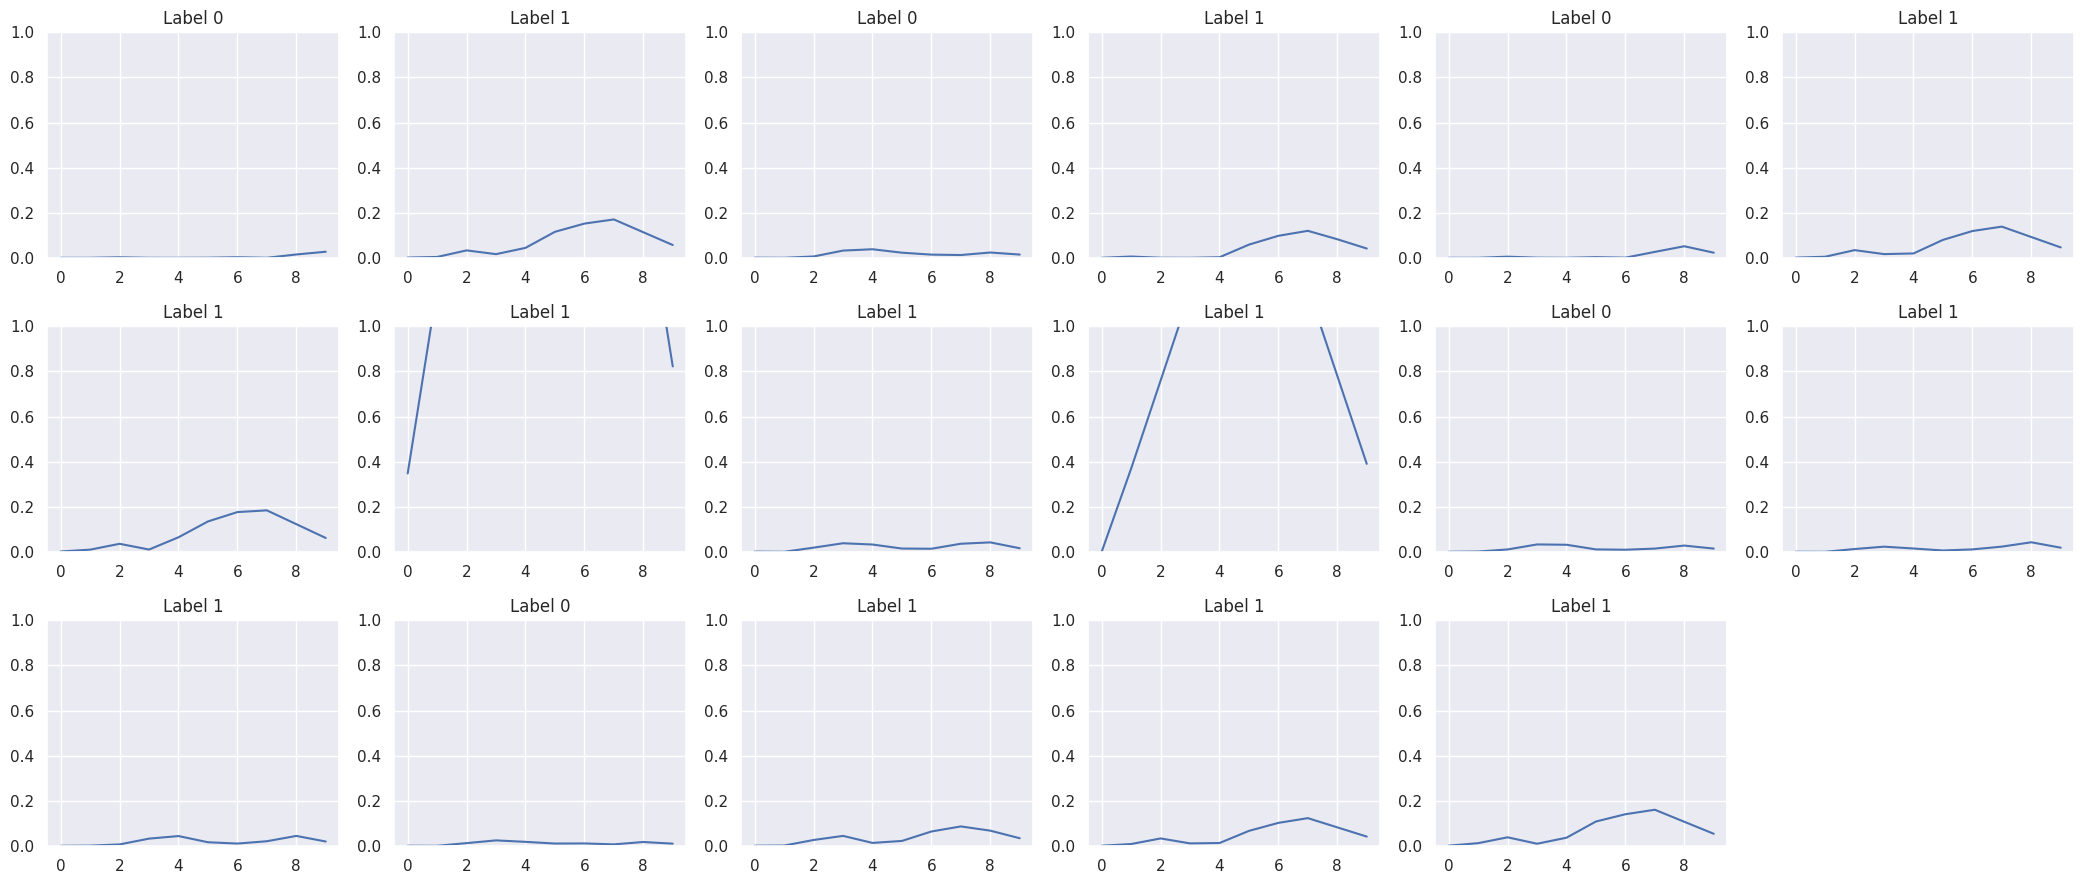

In [38]:
# Vectorize the PDs then do cluster
# Vectorize by Silhoutte
SilList = PD2Silhoutte(PDList, resolution=10)

#print (SilList)

# Result from R
simplexVolDepthList = [0.9782665, 0.9598752, 0.9803188, 0.9715499, 0.979676, 0.968288, 0.954594, 0.4730382, 0.9818818, 0.6771605, 0.9807952, 0.9813164, 0.9812129, 0.9795362, 0.9805354, 0.9723188, 0.962765, 0.000]

fig, axs = plt.subplots(3, 6, figsize=(21, 9))
for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            axs[i, j].plot(SilList[i*6 + j])
            axs[i, j].set_ylim(0, 1)
            #axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], simplexVolDepthList[i*6 + j]))
            axs[i, j].title.set_text('Label {}'.format(groundTruth[i*6 + j]))
fig.delaxes(axs[2, 5])
plt.tight_layout()
plt.show()

In [15]:
results = {}
results['pds']= {}
results['Silhoutte']= {}
params = {}
params['pds']= {}
params['Silhoutte']= {}
clusters = {}
clusters['pds']= {}
clusters['Silhoutte']= {}

In [16]:
# Do cluster on Silhoutte
# Calculate distance matrix
totalTimeStep = len(channel7List)
l2dist = np.zeros((totalTimeStep,totalTimeStep))
for i in range(totalTimeStep):
    a = SilList[i]
    for j in range(i+1):
        b = SilList[j]
        l2dist[i,j] = np.linalg.norm(a - b)
        l2dist[j,i] = l2dist[i,j]

l2dist=(l2dist-np.min(l2dist))/(np.max(l2dist)-np.min(l2dist))

In [17]:
# Do cluster
eps={'min':0.01, 'max':10, 'inc': 0.005}
results['Silhoutte']['DBSCAN'] = {}
params['Silhoutte']['DBSCAN'] = {}
clusters['Silhoutte']['DBSCAN'] = {}

scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['Silhoutte']['DBSCAN'][score] = {}
    params['Silhoutte']['DBSCAN'][score] = {}
    clusters['Silhoutte']['DBSCAN'][score] = {}
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=l2dist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    results['Silhoutte']['DBSCAN'][score]= score_
    params['Silhoutte']['DBSCAN'][score]['eps'] = eps_
    params['Silhoutte']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['Silhoutte']['DBSCAN'][score] = clusters_


======silhouette======
score, best_score, eps, eps_ask, min_samples, min_samples_ask
0.5984180373775762 0.5984180373775762 0.01 0.01 2 2
0.8751178769636967 0.8751178769636967 0.015 0.015 2 2
0.8751178769636967 0.8751178769636967 0.019999999999999997 0.015 2 2
0.8751178769636967 0.8751178769636967 0.024999999999999998 0.015 2 2
0.8751178769636967 0.8751178769636967 0.03 0.015 2 2
0.8751178769636967 0.8751178769636967 0.034999999999999996 0.015 2 2
0.8751178769636967 0.8751178769636967 0.039999999999999994 0.015 2 2
0.8751178769636967 0.8751178769636967 0.045 0.015 2 2
0.8751178769636967 0.8751178769636967 0.049999999999999996 0.015 2 2
0.8751178769636967 0.8751178769636967 0.05499999999999999 0.015 2 2
0.8751178769636967 0.8751178769636967 0.05999999999999999 0.015 2 2
0.8751178769636967 0.8751178769636967 0.06499999999999999 0.015 2 2
0.8751178769636967 0.8751178769636967 0.06999999999999999 0.015 2 2
0.8751178769636967 0.8751178769636967 0.07499999999999998 0.015 2 2
0.875117876963696

In [18]:
for key in clusters['Silhoutte']['DBSCAN'].keys():
    print(key + "," + str(clusters['Silhoutte']['DBSCAN'][key].labels_))

silhouette,[ 0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0]
calinski,[ 0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0]
davies,[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
dunn,[ 0 -1  0  0  0  0 -1 -1  0 -1  0  0  0  0  0  0 -1]
cop,[ 0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0]


In [19]:
def getPreFireIndex(labelIndex): # currently only works for 2 labels (0 & -1)
    '''
    input :: label list from cluster result
    return :: L2 distance to no fire boundary and fire boundary
    '''
    NoFireVector = []
    FireVector = []
    for j in range(len(SilList)):
        if labelIndex[j] == 0:
            NoFireVector.append(SilList[j])
        elif labelIndex[j] == -1:
            FireVector.append(SilList[j])
        else:
            print ('Label went wrong')

    fireCenter = np.mean(FireVector, axis=0)
    noFireCenter = np.mean(NoFireVector, axis=0)

    dis = 0
    disIndex = 0
    for i in range(len(FireVector)):
        tempDis = np.linalg.norm(FireVector[i] - noFireCenter)
        if tempDis > dis:
            disIndex = i
            dis = tempDis

    dis2 = 0
    disIndex2 = 0
    for i in range(len(NoFireVector)):
        tempDis2 = np.linalg.norm(NoFireVector[i] - fireCenter)
        if tempDis2 > dis2:
            disIndex2 = i
            dis2 = tempDis2

    mostLikelyFireVector = FireVector[disIndex]
    mostLikelyNoFireVector = NoFireVector[disIndex2]

    dis2NoFire = []
    dis2Fire = []
    for i in range(len(SilList)):
        d1 = np.linalg.norm(SilList[i] - mostLikelyFireVector)
        d2 = np.linalg.norm(SilList[i] - mostLikelyNoFireVector)
        dis2Fire.append(d1)
        dis2NoFire.append(d2)
    return dis2NoFire, dis2Fire

In [20]:
# build center for label by DBSCAN cluster on dunn score result
labelIndex = clusters['Silhoutte']['DBSCAN']['dunn'].labels_

dis2NoFire, dis2Fire = getPreFireIndex(labelIndex)

In [21]:
def Dis2FireIndex(vector):
    normalizedVec = []
    for x in vector:
        if x < 1:
            normalizedVec.append(x)
        if x >= 1:
            normalizedVec.append(1)
    return normalizedVec

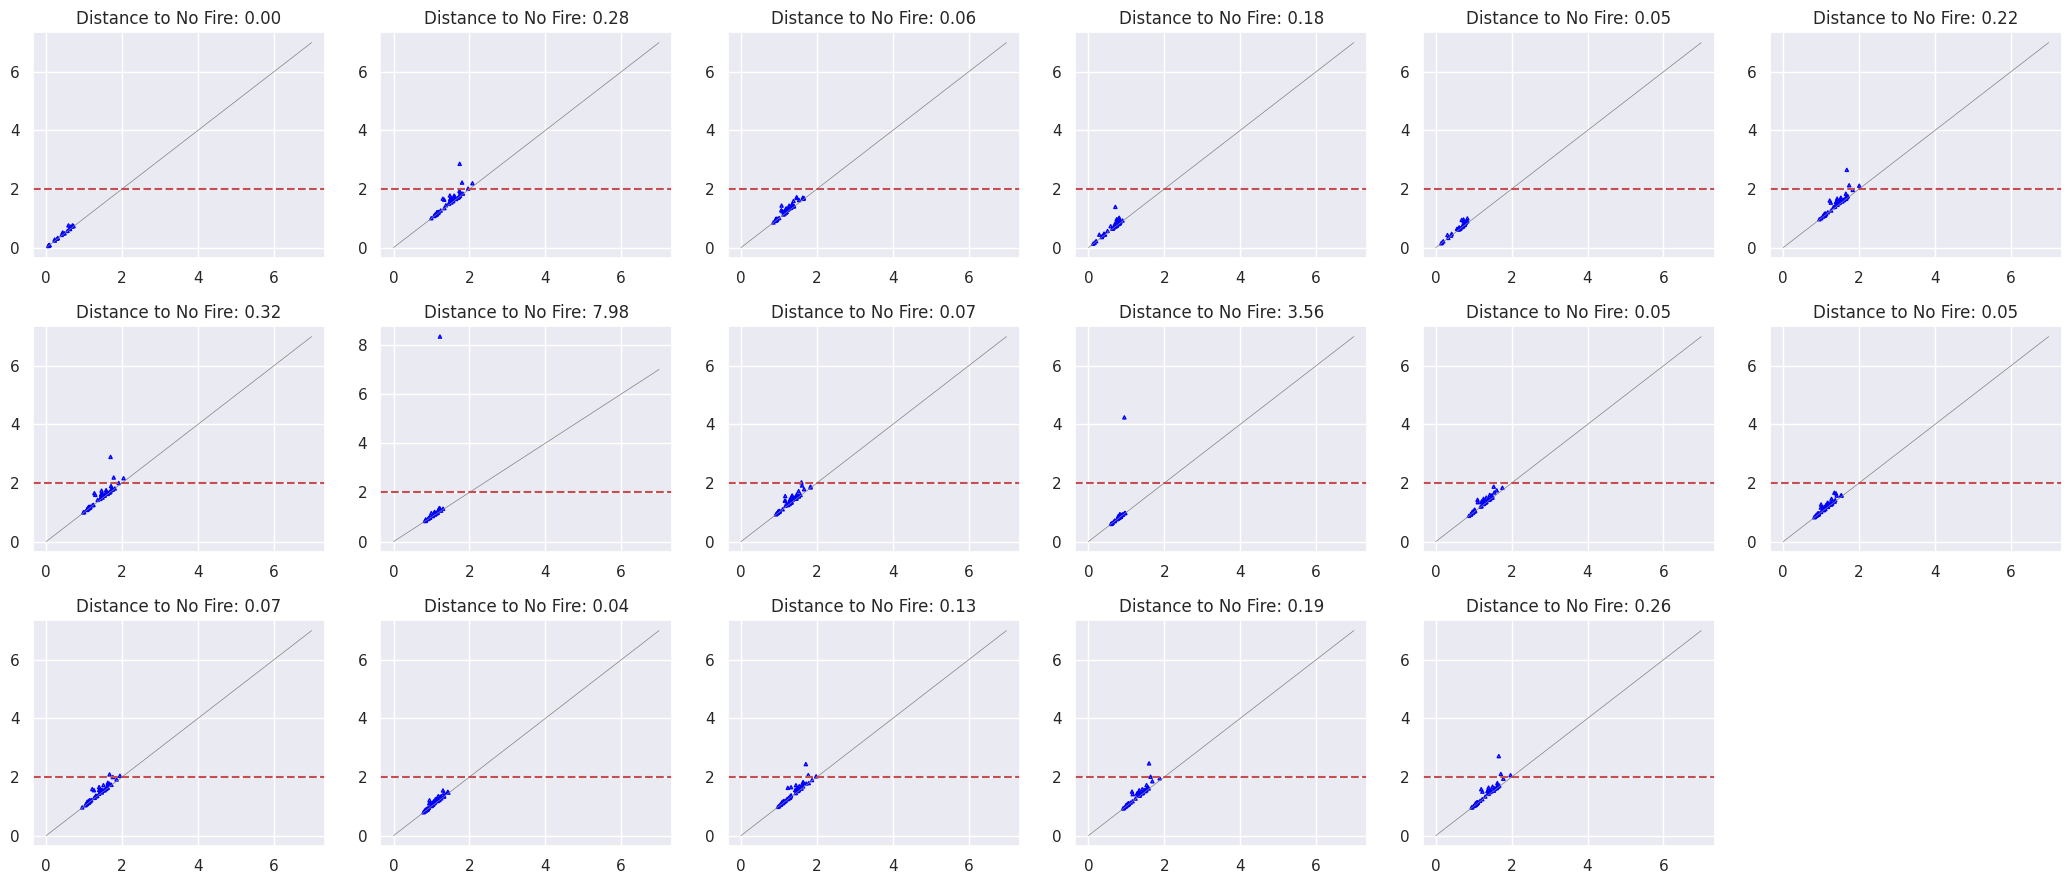

In [22]:
fig, axs = plt.subplots(3, 6, figsize=(21, 9))

for i in range(3):
    for j in range(6):
        if i* 6 + j <= 16:
            lower_bound = 0
            upper_bound = 8

            p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(channel7List[i* 6 + j], lower_bound = lower_bound, upper_bound = upper_bound)

            axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
            axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
            axs[i, j].axhline(y = 2, color='r', linestyle='--')
            axs[i, j].title.set_text('Distance to No Fire: {0:.2f}'.format(dis2NoFire[i*6+j]))

plt.tight_layout()
fig.delaxes(axs[2, 5])
plt.show()

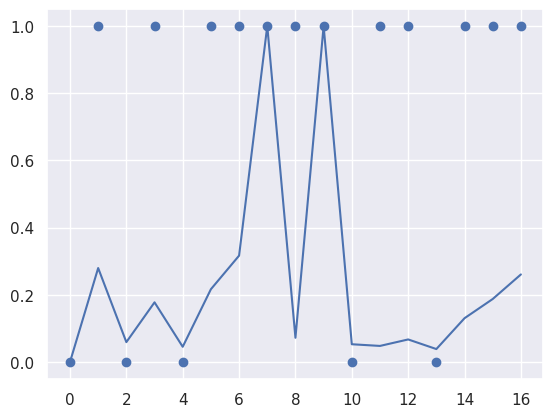

In [23]:
#plt.plot(dis2NoFire)
plt.plot(Dis2FireIndex(dis2NoFire))
plt.scatter(range(0, 17), groundTruth)
plt.show()

In [24]:
# cluster Silhouette by Hierarchical

results['Silhoutte']['Hierarchical'] = {}
params['Silhoutte']['Hierarchical'] = {}
clusters['Silhoutte']['Hierarchical'] = {}

scores=['silhouette', 'calinski', 'davies', 'dunn','cop'] #'cop'
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['Silhoutte']['Hierarchical'][score] = {}
    params['Silhoutte']['Hierarchical'][score] = {}
    clusters['Silhoutte']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=l2dist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['Silhoutte']['Hierarchical'][score]=score_
    params['Silhoutte']['Hierarchical'][score]['n']=n
    params['Silhoutte']['Hierarchical'][score]['linkage']=linkage
    clusters['Silhoutte']['Hierarchical'][score]=clusters_


======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.8592680928267341 0.8592680928267341 2 2 complete complete
0.8592680928267341 0.8592680928267341 2 2 average complete
0.8592680928267341 0.8592680928267341 2 2 single complete
0.8546410192674367 0.8592680928267341 3 2 complete complete
0.8546410192674367 0.8592680928267341 3 2 average complete
0.8546410192674367 0.8592680928267341 3 2 single complete
0.5890788267992983 0.8592680928267341 4 2 complete complete
0.5890788267992983 0.8592680928267341 4 2 average complete
0.5890788267992983 0.8592680928267341 4 2 single complete
0.5842411803380487 0.8592680928267341 5 2 complete complete
0.5842411803380487 0.8592680928267341 5 2 average complete
0.43907975330052607 0.8592680928267341 5 2 single complete
0.5256561470764529 0.8592680928267341 6 2 complete complete
0.5256561470764529 0.8592680928267341 6 2 average complete
0.5256561470764529 0.8592680928267341 6 2 single complete
======calinski======
score, best_score, i

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

3 complete complete
0.22743347806261702 0.019714666315374406 6 3 average complete
0.22743347806261696 0.019714666315374406 6 3 single complete
======dunn======
score, best_score, i, n_ask, linkage, linkage_ask
1.3145605870178367 1.3145605870178367 2 2 complete complete
1.3145605870178367 1.3145605870178367 2 2 average complete
1.3145605870178367 1.3145605870178367 2 2 single complete
14.55132434879506 1.3145605870178367 3 2 complete complete
14.55132434879506 1.3145605870178367 3 2 average complete
14.55132434879506 1.3145605870178367 3 2 single complete
0.4034080243914517 0.4034080243914517 4 4 complete complete
0.4034080243914517 0.4034080243914517 4 4 average complete
0.4034080243914517 0.4034080243914517 4 4 single complete
0.5064103303969054 0.4034080243914517 5 4 complete complete
0.5064103303969054 0.4034080243914517 5 4 average complete
0.44932002674165233 0.4034080243914517 5 4 single complete
0.8086445325961861 0.4034080243914517 6 4 complete complete
0.8086445325961861 0.403

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

In [25]:
for key in clusters['Silhoutte']['Hierarchical'].keys():
    print(key + "," + str(clusters['Silhoutte']['Hierarchical'][key].labels_))

silhouette,[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
calinski,[0 1 0 4 0 4 1 3 0 5 0 0 0 0 2 4 1]
davies,[0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0]
dunn,[1 0 1 0 1 0 0 3 1 2 1 1 1 1 0 0 0]
cop,[0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0]


In [26]:
# Added March 2
# Do cluster on PDs

totalTimeStep = len(channel7List)
wdist = np.zeros((totalTimeStep,totalTimeStep))
for i in range(totalTimeStep):
    xs= np.concatenate((pd0_union[i][0][:], pd1_union[i][0][:]), axis=0)
    ys= np.concatenate((pd0_union[i][1][:], pd1_union[i][1][:]), axis=0)
    Di = np.transpose([xs,ys])

    for j in range(i+1):
        #print(i,j)
        xs= np.concatenate((pd0_union[j][0][:], pd1_union[j][0][:]), axis=0)
        ys= np.concatenate((pd0_union[j][1][:], pd1_union[j][1][:]), axis=0)
        Dj = np.transpose([xs,ys])

        wdist[i,j] = wd(Di, Dj, order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
        wdist[j,i] = wdist[i,j]

In [27]:
wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [28]:
eps={'min':0.01, 'max':10, 'inc': 0.005}
results['pds']['DBSCAN'] = {}
params['pds']['DBSCAN'] = {}
clusters['pds']['DBSCAN'] = {}

scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pds']['DBSCAN'][score] = {}
    params['pds']['DBSCAN'][score] = {}
    clusters['pds']['DBSCAN'][score] = {}
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=wdist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    results['pds']['DBSCAN'][score]= score_
    params['pds']['DBSCAN'][score]['eps'] = eps_
    params['pds']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['pds']['DBSCAN'][score] = clusters_


Streaming output truncated to the last 5000 lines.
53.24563612322202 53.24563612322202 0.44499999999999995 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.44999999999999996 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.45499999999999996 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.45999999999999996 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.4649999999999999 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.4699999999999999 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.4749999999999999 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.4799999999999999 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.48499999999999993 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.48999999999999994 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.49499999999999994 0.40499999999999997 3 2
53.24563612322202 53.24563612322202 0.49999999999999994 0.404999999999999

In [29]:
score='calinski'
clustering = DBSCAN(eps=params['pds']['DBSCAN'][score]['eps'], min_samples=params['pds']['DBSCAN'][score]['min_samples'], metric='precomputed')
clustering.fit(wdist)

DBSCAN(eps=0.40499999999999997, metric='precomputed', min_samples=2)

In [30]:
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [31]:
for key in clusters['pds']['DBSCAN'].keys():
  print(key + "," + str(clusters['pds']['DBSCAN'][key].labels_))

silhouette,[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
calinski,[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
davies,[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
dunn,[-1 -1  0 -1 -1  0 -1 -1  0 -1  0  0  0 -1  0  0 -1]
cop,[ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]


In [32]:
# calculate barycenter here
labelIndex = clustering.labels_

PDList = []
for i in pd1_union:
    temp = np.vstack((i[0], i[1])).T
    PDList.append(temp)

NoFirePD = []
FirePD = []
for j in range(len(PDList)):
    if labelIndex[j] == 0:
        NoFirePD.append(PDList[j])
    elif labelIndex[j] == -1:
        FirePD.append(PDList[j])
    else:
        print ('Label went wrong')

baryCenterNoFire = lagrangian_barycenter(pdiagset=NoFirePD, init=None)
baryCenterFire = lagrangian_barycenter(pdiagset=FirePD, init=None)

dis = 0
disIndex = 0
for i in range(len(NoFirePD)):
    tempDis = gudhi.wasserstein.wasserstein_distance(NoFirePD[i], baryCenterFire, order=2)
    if tempDis > dis:
        disIndex = i
        dis = tempDis

print (gudhi.wasserstein.wasserstein_distance(PDList[7], PDList[9], order=2))
print (gudhi.wasserstein.wasserstein_distance(PDList[7], PDList[0], order=2))
print (gudhi.wasserstein.wasserstein_distance(baryCenterFire, PDList[7], order=2))
print (len(FirePD))
# test change later
#FireFlag = FirePD[4]
#NoFireFlag = NoFirePD[1]

#dis2NoFire = []
#for pd in PDList:
#    d1 = gudhi.wasserstein.wasserstein_distance(pd, FireFlag, order=2)
#    d2 = gudhi.wasserstein.wasserstein_distance(pd, NoFireFlag, order=2)
#    dis2NoFire.append(d2)
#    #print (d2)

3.924992976883225
3.564179447404429
0.0
1


In [33]:
# Cluster with Hierarchical Algo

results['pds']['Hierarchical'] = {}
params['pds']['Hierarchical'] = {}
clusters['pds']['Hierarchical'] = {}

scores=['silhouette', 'calinski', 'davies', 'dunn','cop'] #'cop'
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pds']['Hierarchical'][score] = {}
    params['pds']['Hierarchical'][score] = {}
    clusters['pds']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=wdist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['pds']['Hierarchical'][score]=score_
    params['pds']['Hierarchical'][score]['n']=n
    params['pds']['Hierarchical'][score]['linkage']=linkage
    clusters['pds']['Hierarchical'][score]=clusters_


======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.7871235303356686 0.7871235303356686 2 2 complete complete
0.7871235303356686 0.7871235303356686 2 2 average complete
0.7871235303356686 0.7871235303356686 2 2 single complete
0.5880271206283106 0.7871235303356686 3 2 complete complete
0.5880271206283106 0.7871235303356686 3 2 average complete
0.5880271206283106 0.7871235303356686 3 2 single complete
0.48511332503292537 0.7871235303356686 4 2 complete complete
0.48511332503292537 0.7871235303356686 4 2 average complete
0.48511332503292537 0.7871235303356686 4 2 single complete
0.4322771865294134 0.7871235303356686 5 2 complete complete
0.4322771865294134 0.7871235303356686 5 2 average complete
0.4322771865294134 0.7871235303356686 5 2 single complete
0.40235926603452077 0.7871235303356686 6 2 complete complete
0.2828077219926232 0.7871235303356686 6 2 average complete
0.2828077219926232 0.7871235303356686 6 2 single complete
======calinski======
score, best_score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

0.11064473899980544 6 2 average complete
0.41717976863407175 0.11064473899980544 6 2 single complete
======dunn======
score, best_score, i, n_ask, linkage, linkage_ask
1.8841622972957865 1.8841622972957865 2 2 complete complete
1.8841622972957865 1.8841622972957865 2 2 average complete
1.8841622972957865 1.8841622972957865 2 2 single complete
1.5309300901072673 1.5309300901072673 3 3 complete complete
1.5309300901072673 1.5309300901072673 3 3 average complete
1.5309300901072673 1.5309300901072673 3 3 single complete
0.9667592144793555 0.9667592144793555 4 4 complete complete
0.9667592144793555 0.9667592144793555 4 4 average complete
0.9667592144793555 0.9667592144793555 4 4 single complete
0.6223591856594499 0.6223591856594499 5 5 complete complete
0.6223591856594499 0.6223591856594499 5 5 average complete
0.6223591856594499 0.6223591856594499 5 5 single complete
0.6811727733436213 0.6223591856594499 6 5 complete complete
0.5872723269163705 0.5872723269163705 6 6 average average
0.5872

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

In [34]:
for key in clusters['pds']['Hierarchical'].keys():
  print(key + "," + str(clusters['pds']['Hierarchical'][key].labels_))

silhouette,[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
calinski,[1 2 0 1 1 4 2 3 0 5 0 0 0 0 4 4 4]
davies,[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
dunn,[4 0 1 4 4 0 0 3 1 5 1 1 2 1 0 0 0]
cop,[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [35]:
# Below are for experiment

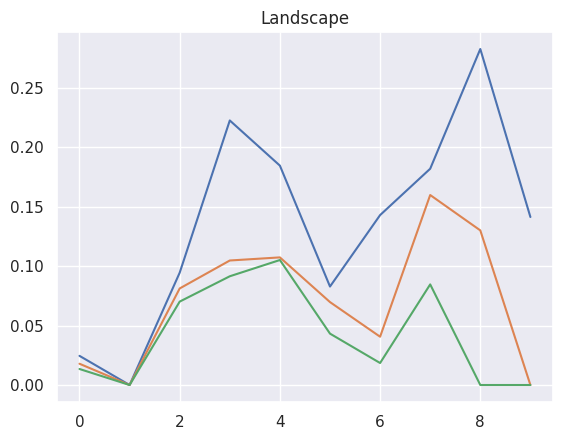

(1, 50)


In [36]:
# Persistent landscape

k = 10
LS = Landscape(resolution=k)
L = LS.fit_transform([PDList[8]])
plt.plot(L[0][:k])
plt.plot(L[0][k:2*k])
plt.plot(L[0][2*k:3*k])
plt.title("Landscape")
plt.show()
print (np.shape(L))

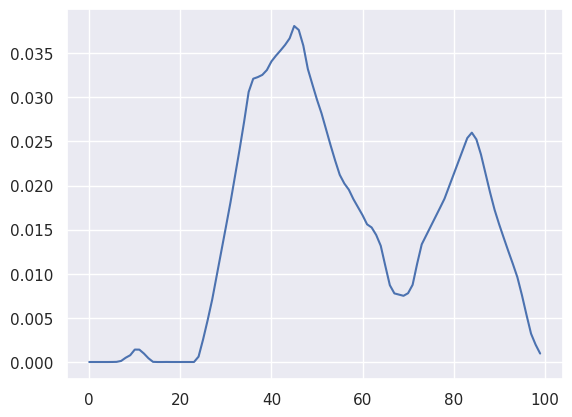

In [37]:
# Silhoutte

SH = gd.representations.Silhouette(resolution=100, weight=lambda x: np.power(x[1]-x[0],1))
sh = SH.fit_transform([PDList[2]])
plt.plot(sh[0])
#plt.ylim(0, 2)

plt.show()